In [1]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import math

In [2]:
def imOpen(imageFileName):
    buffer = BytesIO()
    imageFile = open(imageFileName, 'rb')
    buffer.write(imageFile.read())
    buffer.seek(0)
    imageFile.close()

    originalImage = Image.open(buffer)

    width = originalImage.size[0]
    height = originalImage.size[1]
    image = Image.new('L', (width,height))
    for x in range(0, width):
        for y in range(0, height):
            r, g, b = originalImage.getpixel((x, y))
            color = 0.3 * r + 0.59 * g + 0.11 * b
            image.putpixel((x, y), int(color))
    
    return image

In [3]:
def displayImage(image):
  plt.imshow(image, cmap="gray")

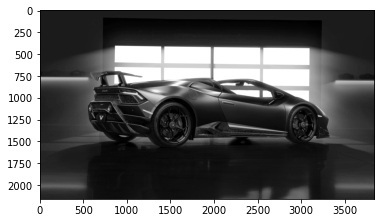

In [4]:
l4 = imOpen("inputs/L4.jpg")
displayImage(l4)

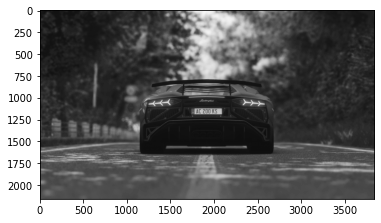

In [5]:
l4b = imOpen("inputs/L4b.jpg")
displayImage(l4b)

In [6]:
def convertImageToArray(image):
  pixels = list(image.getdata())
  width, height = l4.size
  pixels = list(l4.getdata())
  return [[pixels[i * width + j] for j in range(width)] for i in range(height)]

In [7]:
def convertArrayToImage(array):
  width = len(array[0])
  height = len(array)
  image = Image.new('L', (width, height))
  for y in range(height):
    for x in range(width):
      image.putpixel((x, y), int(array[y][x]))
  return image

# Integral Image and Local Sum Calculation

In [8]:
def CalculateIntegral(imageArray):
  n = len(imageArray)
  m = len(imageArray[0])
  ii = [[0 for j in range(m)] for i in range(n)]
  for i in range(n):
    for j in range(m):
      cell = imageArray[i][j]
      if i > 0:
        cell += ii[i - 1][j]
      if j > 0:
        cell += ii[i][j - 1]
      if i > 0 and j > 0:
        cell -= ii[i - 1][j - 1]
      ii[i][j] = cell
  return ii


In [9]:
# Calculate integral image for both images
iiL4 = CalculateIntegral(convertImageToArray(l4))
iiL4b = CalculateIntegral(convertImageToArray(l4b))

In [10]:
def CalculateLocalSum(ii, p0, p1):
  # endPointRow, endPointCol = p1[1], p1[0]
  # startPointRow, startPointCol = p0[1], p0[0]

  endPointRow, endPointCol = p1[0], p1[1]
  startPointRow, startPointCol = p0[0], p0[1]

  sum = ii[endPointRow][endPointCol]

  if startPointRow > 0:
    sum -= ii[startPointRow - 1][endPointCol]

  if startPointCol > 0:
    sum -= ii[endPointRow][startPointCol - 1]

  if startPointRow > 0 and startPointCol > 0:
    sum += ii[startPointRow - 1][startPointCol - 1]

  return sum


In [11]:
CalculateLocalSum(iiL4, (0, 0), (2000, 2000))

251212488

In [12]:
CalculateLocalSum(iiL4b, (500, 200), (2000, 2000))

190606298

# Kernel Convolution

In [13]:
def print2D(array):
  for i in range(len(array)):
    for j in range(len(array[i])):
      print(array[i][j], end=" ")
    print()

In [14]:
def prewittKernal(x, y, ii, kernalSize):
  n = kernalSize
  
  h1Upper = CalculateLocalSum(ii, (y - n // 2, x - n // 2), (y - 1, x + n // 2))
  h1Lower = CalculateLocalSum(ii, (y + 1, x - n // 2), (y + n // 2, x + n // 2))
  h1 = h1Upper - h1Lower

  h2Left = CalculateLocalSum(ii, (y - n // 2, x - n // 2), (y + n // 2, x - 1))
  h2Right = CalculateLocalSum(ii, (y - n // 2, x + 1), (y + n // 2, x + n // 2))
  h2 = h2Right - h2Left

  return math.sqrt(h1 ** 2 + h2 ** 2)

In [15]:
def laplaceKernal(x, y, ii, kernalSize):
  n = kernalSize

  allSum = CalculateLocalSum(ii, (y - n // 2, x - n // 2), (y + n // 2, x + n // 2))
  middle = CalculateLocalSum(ii, (y, x), (y, x))

  result = -allSum + middle + middle * (n ** 2 - 1)

  return abs(result)

In [16]:
def meanKernal(x, y, ii, kernalSize):
  n = kernalSize
  sum = CalculateLocalSum(ii, (y - n // 2, x - n // 2), (y + n // 2, x + n // 2))
  return sum // (n ** 2)

In [17]:
def EdgeDetect(ii, kernalSize):
  width = len(ii[0])
  height = len(ii)
  prewitt = [[0 for x in range(width)] for y in range(height)]
  laplace = [[0 for x in range(width)] for y in range(height)]
  for y in range(height):
    for x in range(width):
      if fitInKernal(x, y, width, height, kernalSize):
        prewitt[y][x] = prewittKernal(x, y, ii, kernalSize)
        laplace[y][x] = laplaceKernal(x, y, ii, kernalSize)
      # else:
      #   pixelValue = CalculateLocalSum(ii, (y, x), (y, x))
      #   prewitt[y][x] = pixelValue
      #   laplace[y][x] = pixelValue
  return prewitt, laplace

def fitInKernal(x, y, width, height, kernalSize):
  midStep = kernalSize // 2
  if x - midStep < 0 or x + midStep >= width:
    return False
  if y - midStep < 0 or y + midStep >= height:
    return False
  return True

In [18]:
l4D1, l4D2 = EdgeDetect(iiL4, 101)
l4ImageD1 = convertArrayToImage(l4D1)
l4ImageD2 = convertArrayToImage(l4D2)

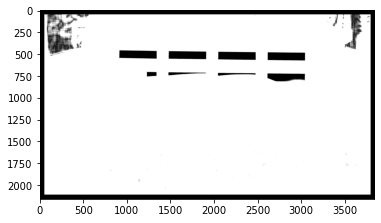

In [19]:
displayImage(l4ImageD1)

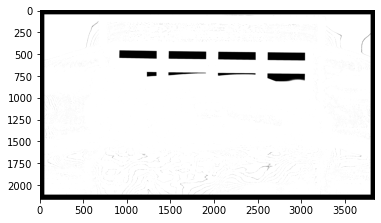

In [20]:
displayImage(l4ImageD2)